In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from flux.shape import CgalTrimeshShapeModel, get_surface_normals

import pyvista as pv

# Clique Clustering on Mesh

Using the adjacency matrix induced by the uncompressed form factor, extract "cliques" which are "almost" fully-connected sub-graphs in the induced graph. The cliques should correspond to sets of triangles which are "mostly" mutually visible.

### Use the full form factor to extract cliques.

In [4]:
mesh_dir = 'python-flux/examples/shackleton_vary_outer/'
mesh_name = 'shackleton'

In [82]:
FF = scipy.sparse.load_npz(f"{mesh_dir}/results/true_3.0_80/FF_3.0_80.npz")
FF_arr = FF.A
adjacency_FF = np.zeros(FF_arr.shape)
adjacency_FF[FF_arr > 0] = 1.
unweighted_FF = np.copy(adjacency_FF)
FF.nnz

4446052


In [85]:
from tqdm import tqdm

all_pseudo_cliques = []
for i in tqdm(np.random.permutation(unweighted_FF.shape[0])):
    
    # make sure the seed index is not already in a clique
    if np.array([i in _pseudo_clique for _pseudo_clique in all_pseudo_cliques]).any():
        continue
    
    nonzero_idx = list((unweighted_FF[i] > 0).nonzero()[0])
    nonzero_idx.append(i)
    nonzero_idx = np.array(nonzero_idx)
    
    # find all neighbors (visible triangles) which share a substantial number of neighbors with seed index i
    _nonzero_idx = []
    for j in nonzero_idx:
        
        if j == i:
            _nonzero_idx.append(j)
        
        elif not np.array([j in _pseudo_clique for _pseudo_clique in all_pseudo_cliques]).any():
            this_nonzero_idx = list((unweighted_FF[j] > 0).nonzero()[0])
            this_nonzero_idx.append(j)
            this_nonzero_idx = np.array(this_nonzero_idx)
            num_intersecting = np.intersect1d(nonzero_idx, this_nonzero_idx).shape[0]
            
            if num_intersecting >= 0.5*min(nonzero_idx.shape[0], this_nonzero_idx.shape[0]):
                _nonzero_idx.append(j)
    nonzero_idx = np.array(_nonzero_idx)
    
    pseudo_clique = set(list(np.copy(nonzero_idx)))    
    all_pseudo_cliques.append(pseudo_clique)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11125/11125 [01:10<00:00, 157.69it/s]


### Load the shape model and overlay the cliques which have at least 25 triangles.

In [90]:
V = np.load(f'{mesh_dir}/{mesh_name}_verts_3.0_80.npy')
F = np.load(f'{mesh_dir}/{mesh_name}_faces_3.0_80.npy')

# convert verts from km to m
V *= 1e3

N = get_surface_normals(V, F)
N[N[:, 2] > 0] *= -1

faces_padded = np.concatenate([3*np.ones(F.shape[0],dtype=int).reshape(-1,1), F], axis=1)

shape_model = CgalTrimeshShapeModel(V, F, N)
F.shape

(11125, 3)

In [14]:
grid = pv.PolyData(V, faces=faces_padded.flatten(), n_faces=F.shape[0])
grid.plot()

Widget(value="<iframe src='http://localhost:58993/index.html?ui=P_0x2795e49cad0_1&reconnect=auto' style='width…

In [92]:
grid = pv.PolyData(V, faces=faces_padded.flatten(), n_faces=F.shape[0])

grid['clique'] = np.empty(F.shape[0])
grid['clique'][...] = np.nan
counter = 5
for i, I in enumerate(all_pseudo_cliques):
    if len(list(I)) > 25:
        grid['clique'][list(I)] = counter
        counter += 1
    else:
        grid['clique'][list(I)] = 0.
grid.plot(cmap='rainbow')

Widget(value="<iframe src='http://localhost:58993/index.html?ui=P_0x279711bd0d0_16&reconnect=auto' style='widt…

### Sort the cliques in descending order of size.

Then, the reshuffling of indices according to the cliques can give a sense for the potential concentration of data into form factor matrix blocks generated by the cliques.

In [16]:
all_pseudo_cliques_list = []
for i in range(len(all_pseudo_cliques)):
    all_pseudo_cliques_list.append(list(all_pseudo_cliques[i]))
    
ordered_pseudo_clique_list = []
for new_idx in np.argsort([len(c) for c in all_pseudo_cliques_list])[::-1]:
    ordered_pseudo_clique_list.append(all_pseudo_cliques_list[new_idx])

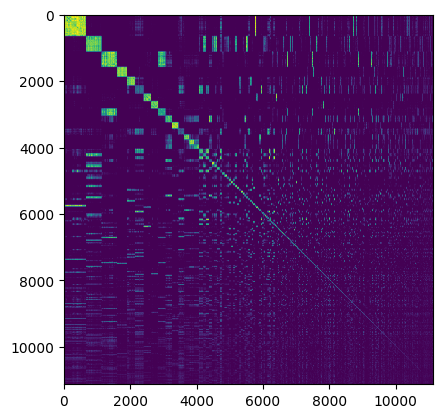

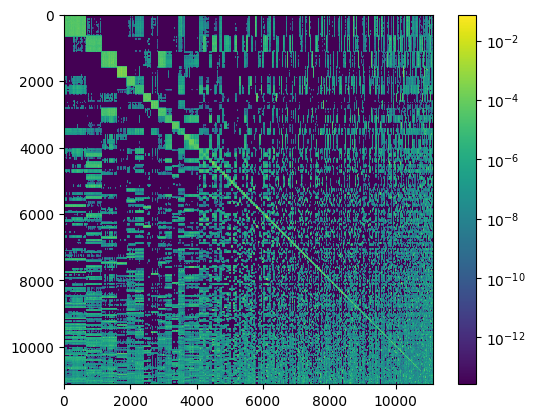

In [18]:
cliqued_idx = []
for i in range(len(ordered_pseudo_clique_list)):
    cliqued_idx += list(ordered_pseudo_clique_list[i])
shuffled_adjacency_FF = np.copy(adjacency_FF[cliqued_idx][:,cliqued_idx])
shuffled_FF = np.copy(FF_arr[cliqued_idx][:,cliqued_idx])
shuffled_FF[shuffled_FF==0] = shuffled_FF[shuffled_FF>0].min()

plt.imshow(shuffled_adjacency_FF)
plt.show()

plt.imshow(shuffled_FF, norm=LogNorm())
plt.colorbar()
plt.show()

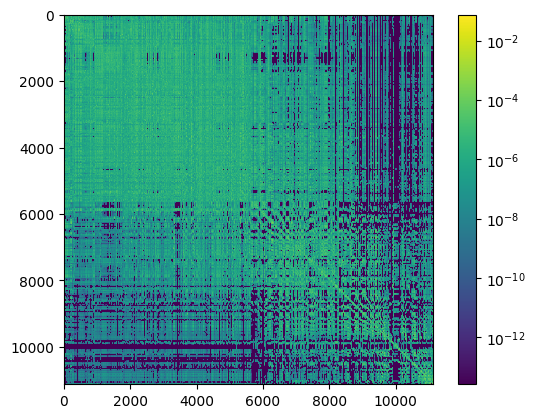

In [21]:
nonshuffled_FF = np.copy(FF_arr)
nonshuffled_FF[nonshuffled_FF==0] = nonshuffled_FF[nonshuffled_FF>0].min()

plt.imshow(nonshuffled_FF, norm=LogNorm())
plt.colorbar()
plt.show()